# Credit Card Fraud Detection System

# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Count')

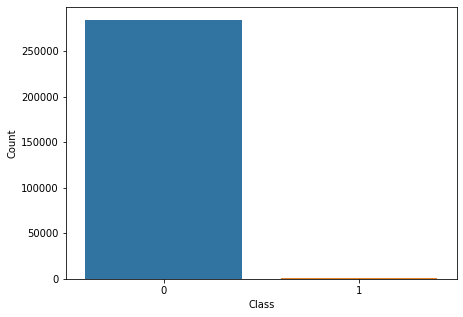

In [3]:
x= df['Class']
plt.figure(figsize=(7,5))
sns.countplot(df['Class'])
plt.xlabel('Class')
plt.ylabel('Count')

In [4]:
fraud_df= df[df['Class']==1]
nonfraud_df= df[df['Class']==0]

print ("Total Transactions : ",df.shape)
print ("Frauds : ",fraud_df.shape)
print ("Non Frauds : ",nonfraud_df.shape)

Total Transactions :  (284807, 31)
Frauds :  (492, 31)
Non Frauds :  (284315, 31)


# EDA

Describing the dataframe, we can see that all features are numeric but are not standardised. Hence we will standardise them using a Scaler in further steps.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There are no missing values in our data:

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Let us plot all the Fraudlent Transaction with respect to amount.

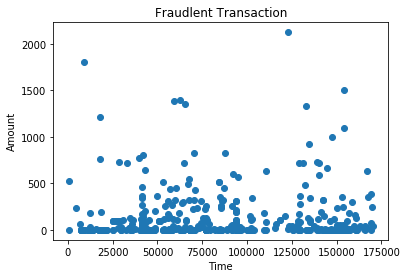

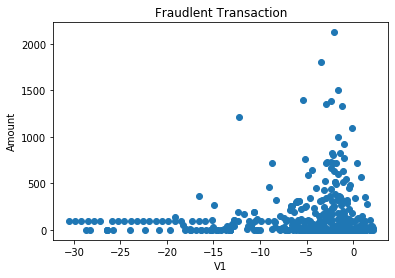

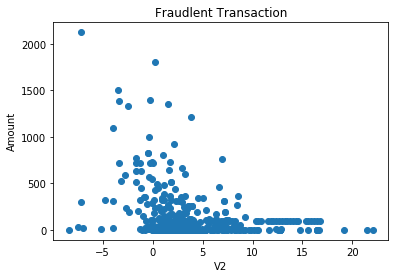

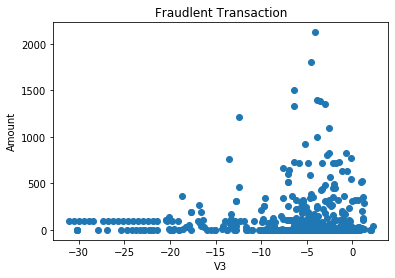

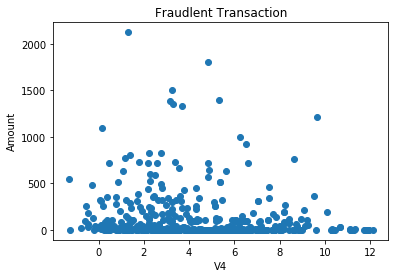

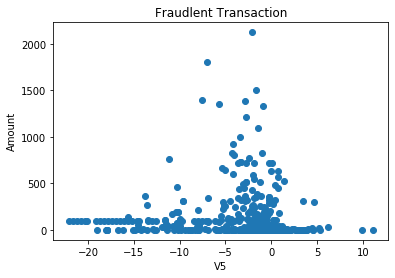

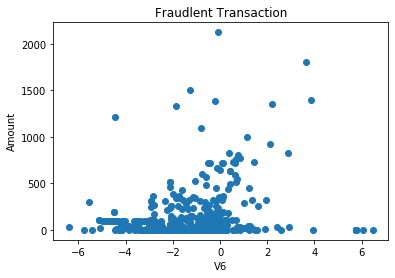

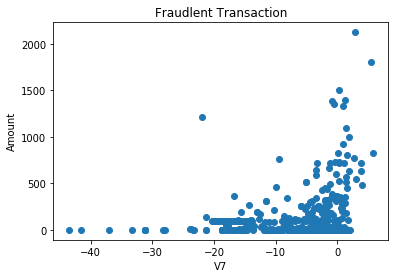

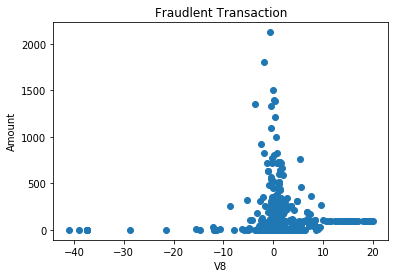

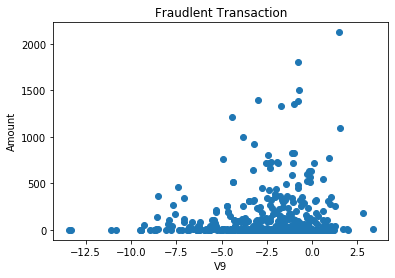

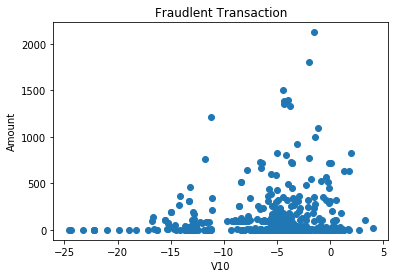

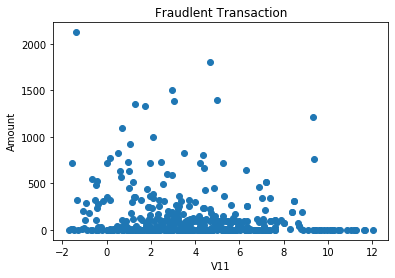

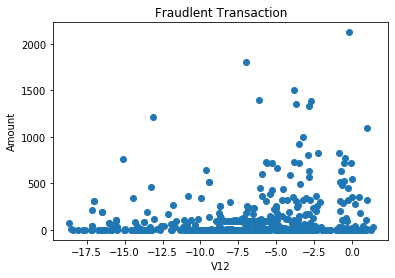

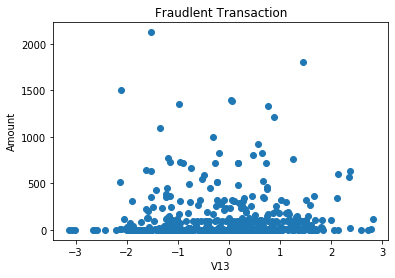

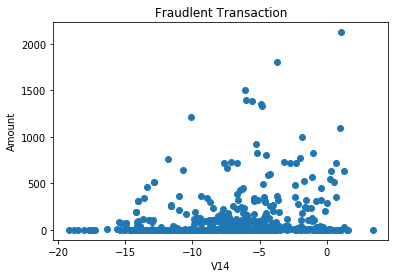

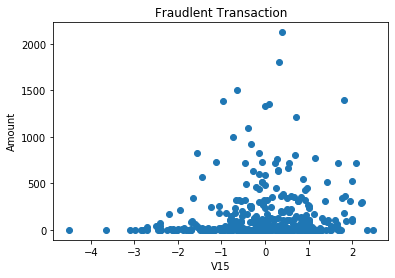

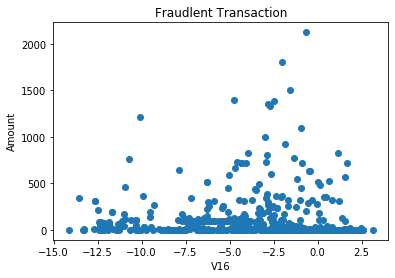

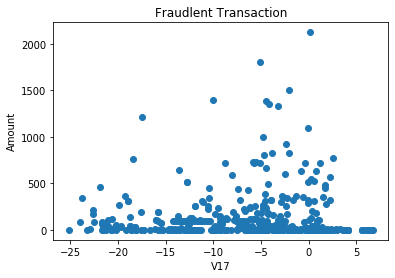

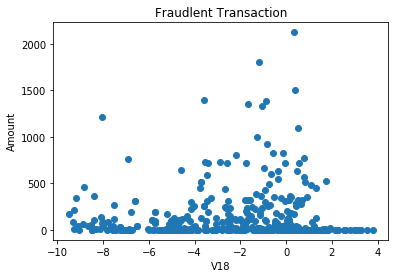

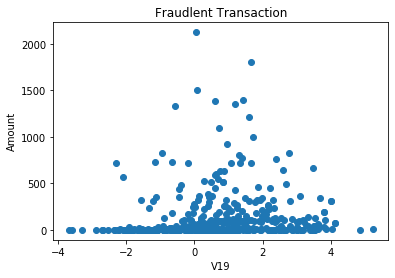

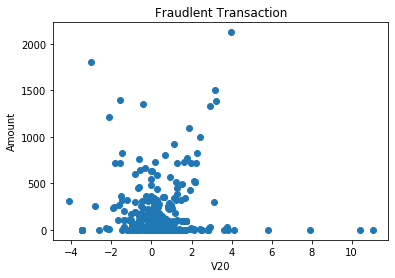

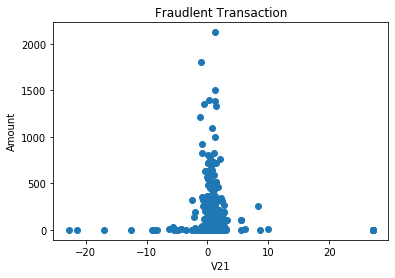

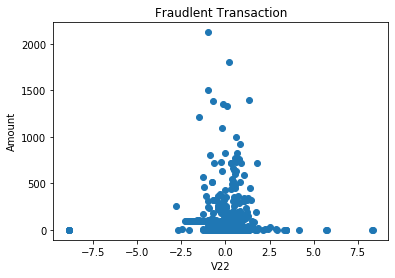

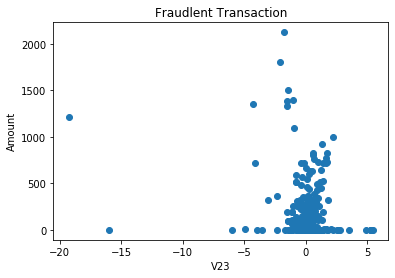

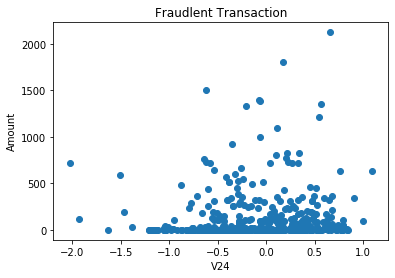

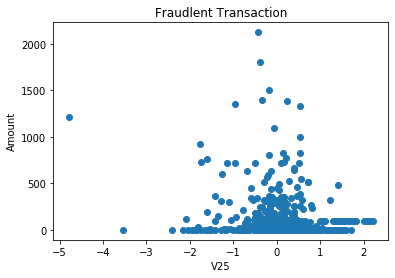

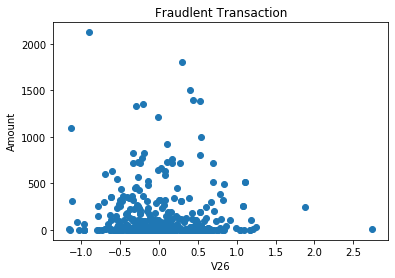

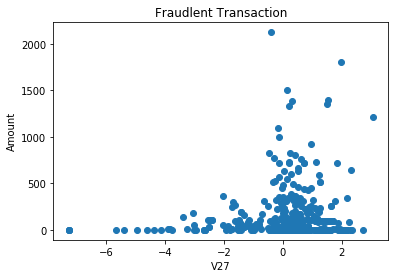

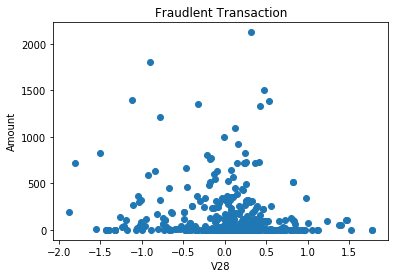

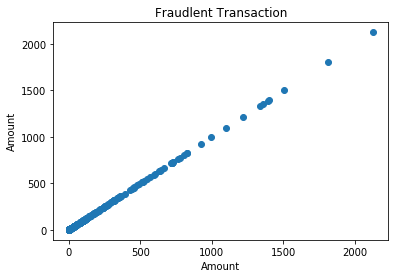

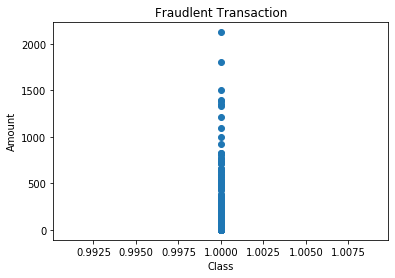

In [7]:
for f in fraud_df.columns:
    plt.title('Fraudlent Transaction')
    plt.xlabel(f)
    plt.ylabel('Amount')
    plt.scatter(fraud_df[f],fraud_df['Amount'])
    plt.show()

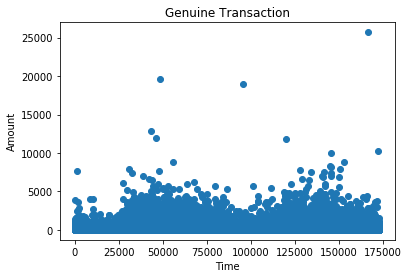

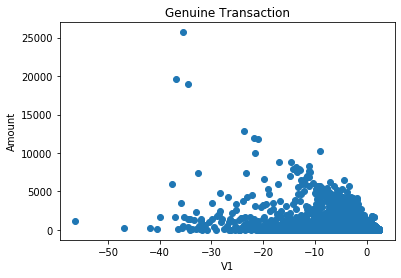

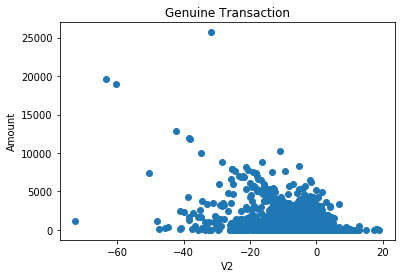

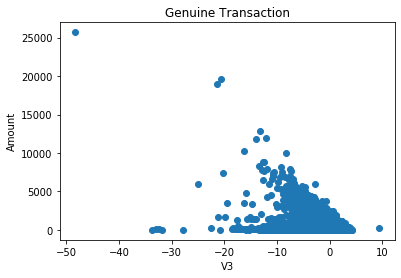

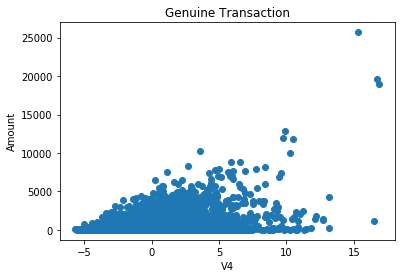

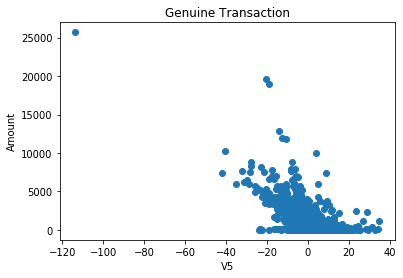

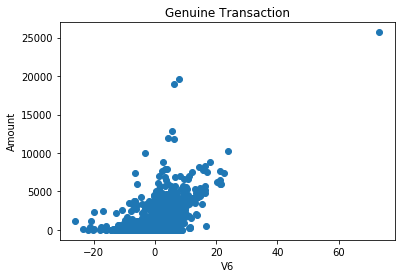

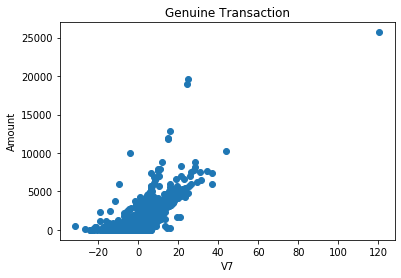

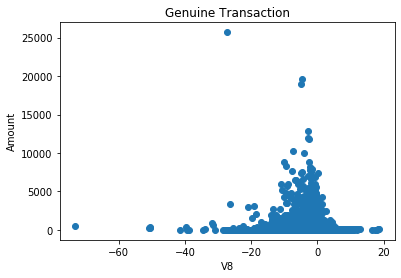

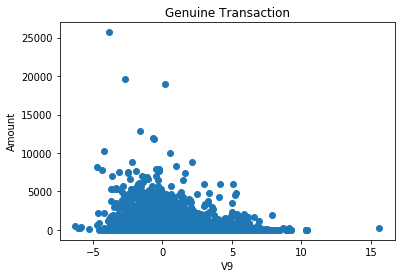

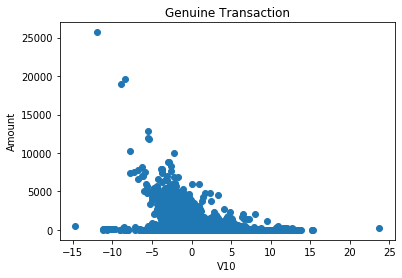

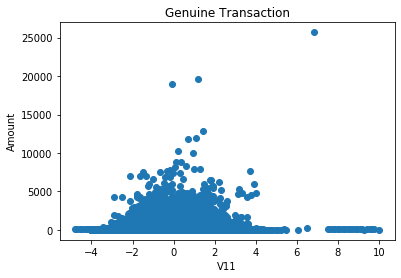

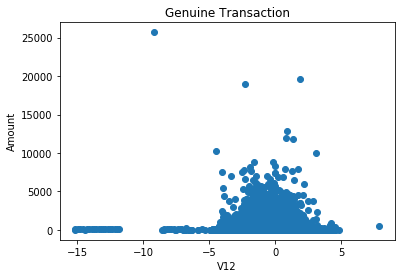

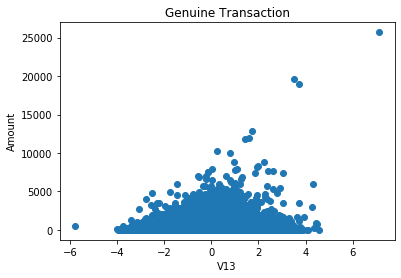

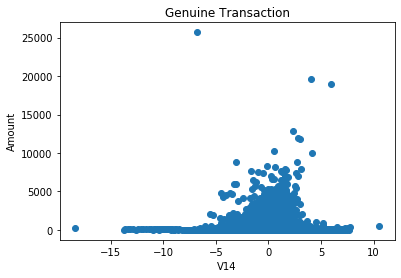

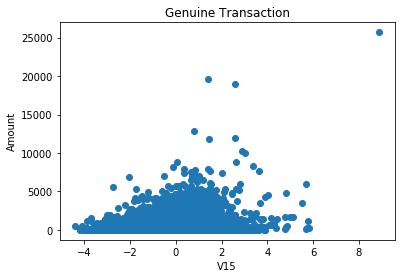

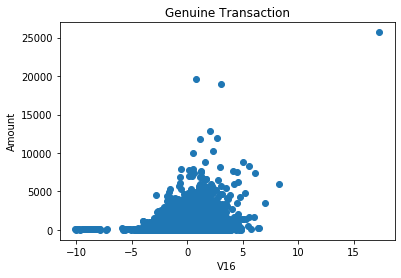

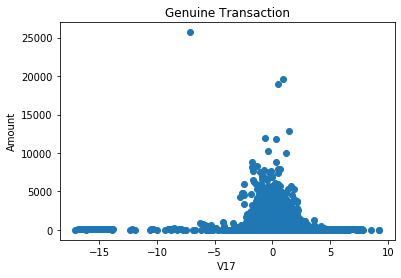

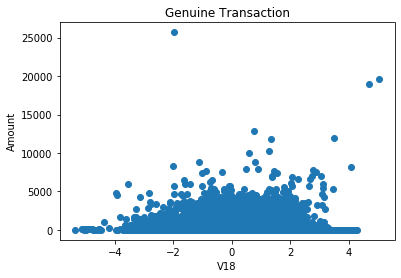

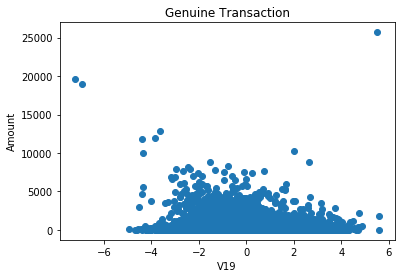

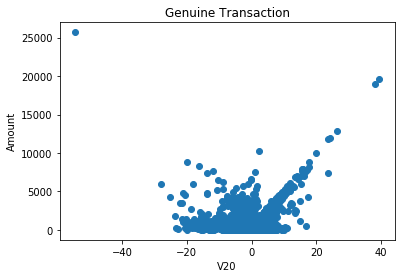

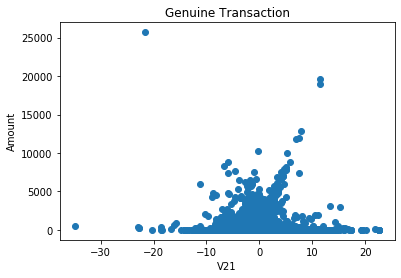

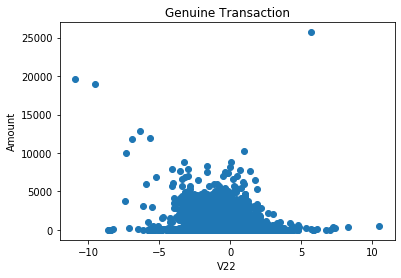

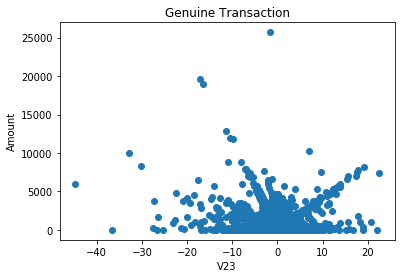

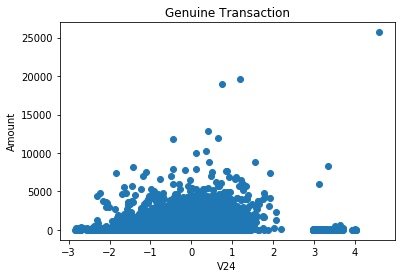

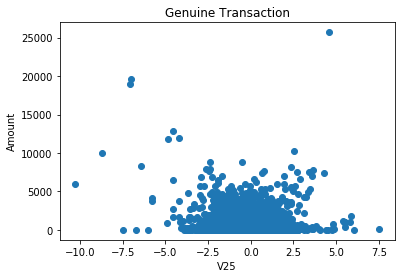

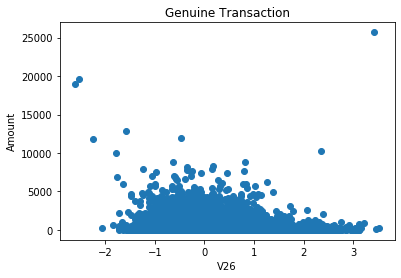

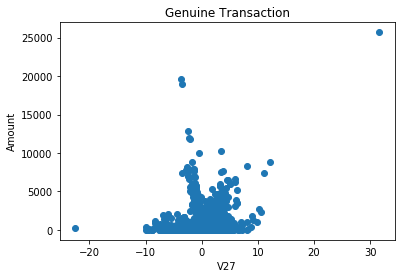

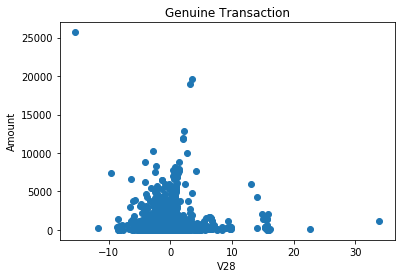

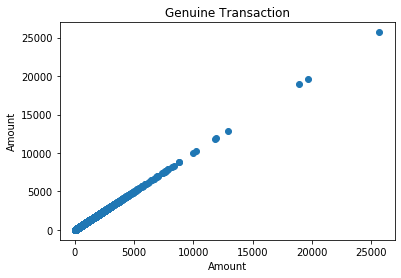

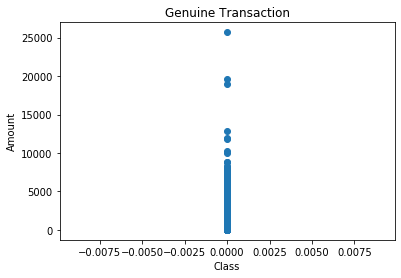

In [8]:
for g in nonfraud_df.columns:
    plt.title('Genuine Transaction')
    plt.xlabel(g)
    plt.ylabel('Amount')
    plt.scatter(nonfraud_df[g],nonfraud_df['Amount'])
    plt.show()

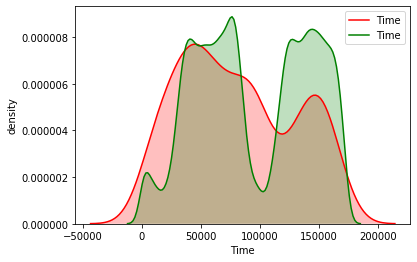

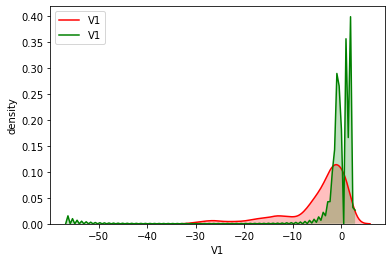

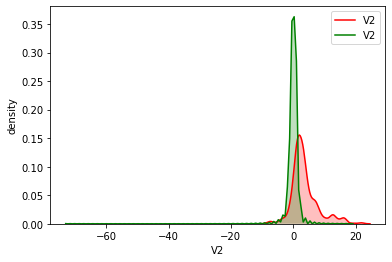

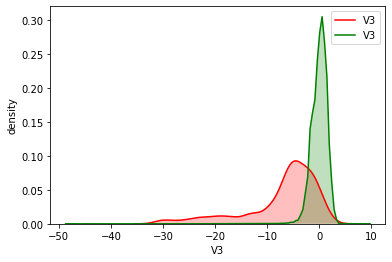

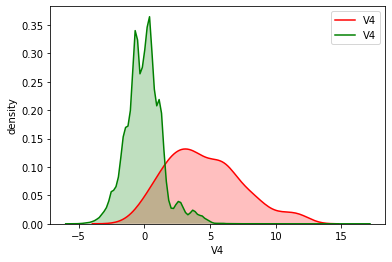

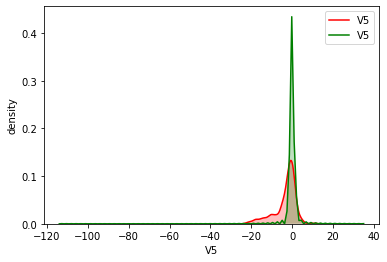

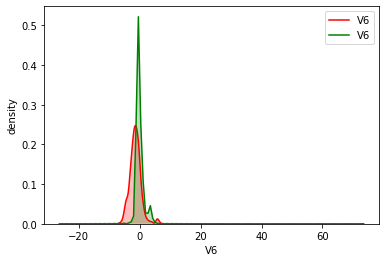

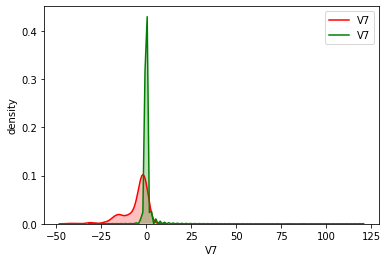

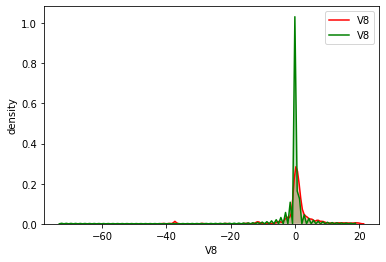

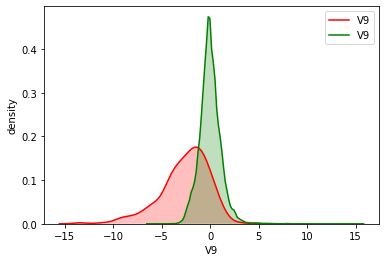

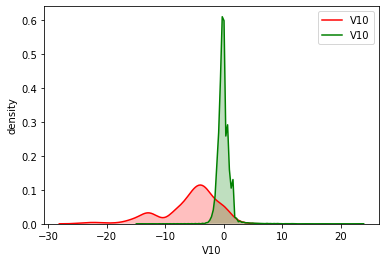

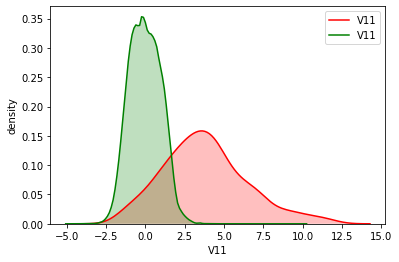

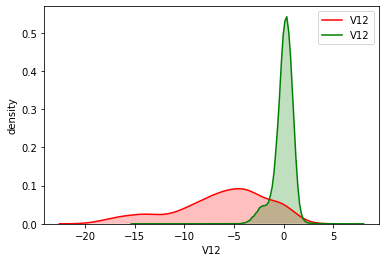

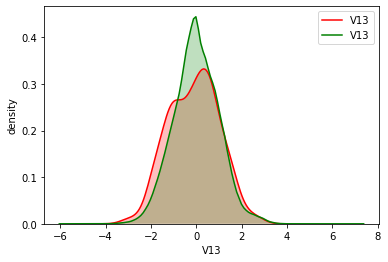

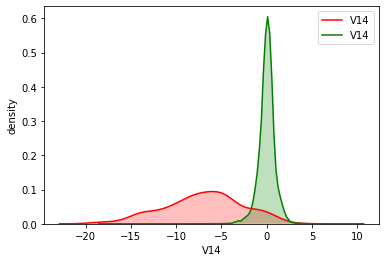

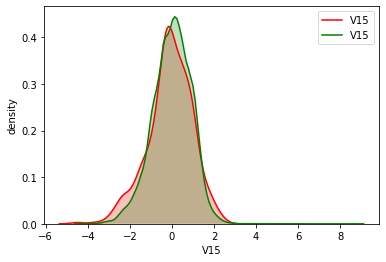

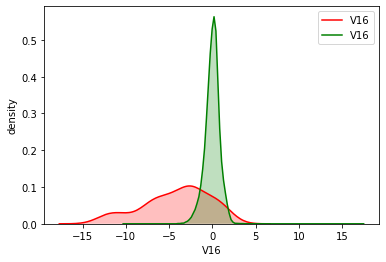

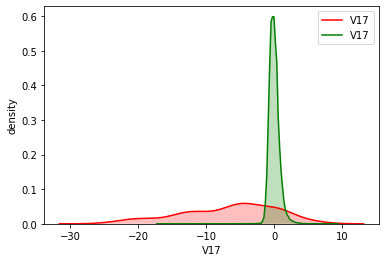

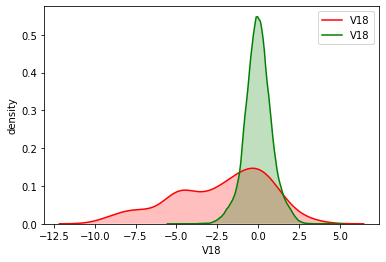

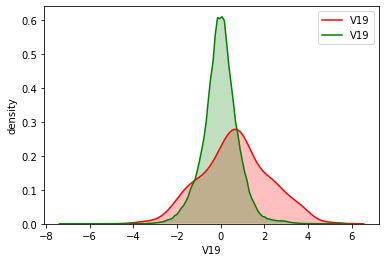

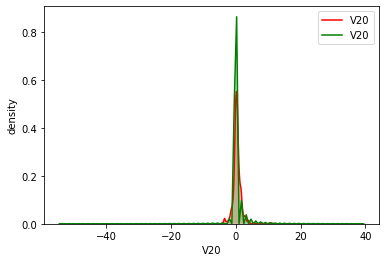

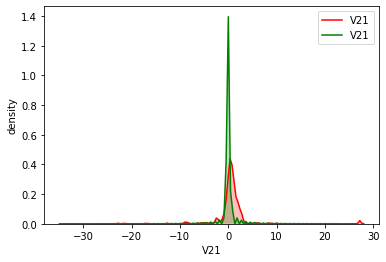

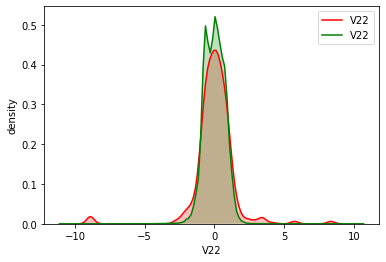

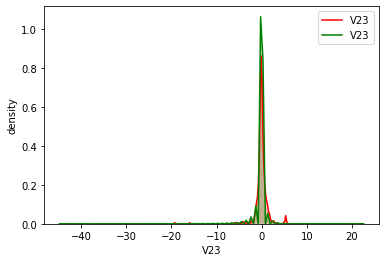

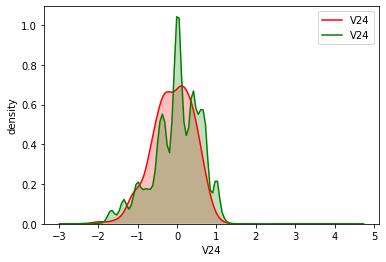

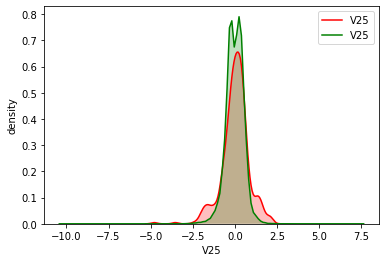

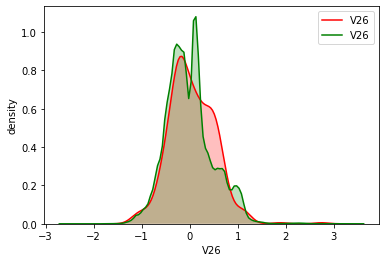

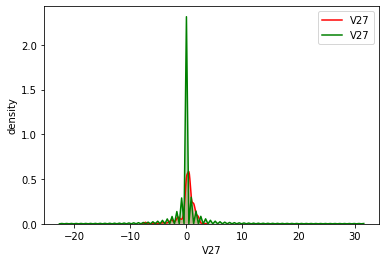

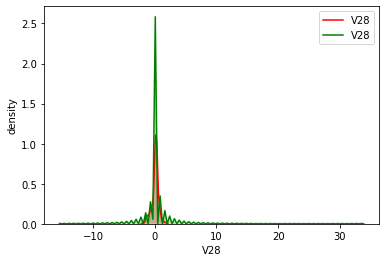

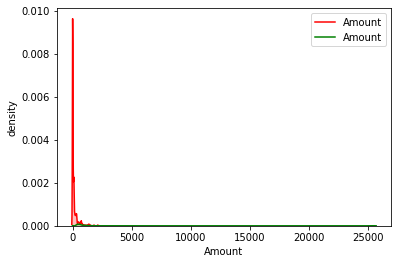

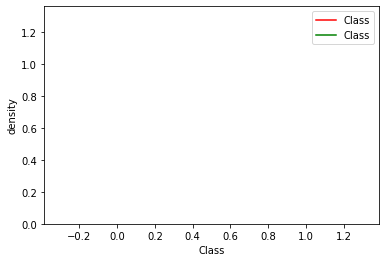

In [9]:
for i,j in zip(fraud_df.columns,nonfraud_df.columns):
    sns.kdeplot(fraud_df[i],color='r',shade=True)
    sns.kdeplot(nonfraud_df[i],color='g',shade=True)
    plt.xlabel(i)
    plt.ylabel('density')
    plt.show()

Now Let us verify how the individual features are correlated with the class using Pearson Test

In [10]:
from scipy.stats.stats import pearsonr

In [11]:
df_t = df['Class']
df_f = df.drop('Class',axis = 1)

In [12]:
p_test = []
for feature in df_f.columns:
    pearsonr_coefficient,p_value = pearsonr(df_f[feature],df_t)
    print('For feature : ',feature)
    print("pearsonr_coefficient(R) :",abs(round(pearsonr_coefficient,2)))
#     print("p_value :",round(p_value,2))
    if abs(round(pearsonr_coefficient,2)) > 0.1:
        p_test.append(feature)
    print()
print(p_test)

For feature :  Time
pearsonr_coefficient(R) : 0.01

For feature :  V1
pearsonr_coefficient(R) : 0.1

For feature :  V2
pearsonr_coefficient(R) : 0.09

For feature :  V3
pearsonr_coefficient(R) : 0.19

For feature :  V4
pearsonr_coefficient(R) : 0.13

For feature :  V5
pearsonr_coefficient(R) : 0.09

For feature :  V6
pearsonr_coefficient(R) : 0.04

For feature :  V7
pearsonr_coefficient(R) : 0.19

For feature :  V8
pearsonr_coefficient(R) : 0.02

For feature :  V9
pearsonr_coefficient(R) : 0.1

For feature :  V10
pearsonr_coefficient(R) : 0.22

For feature :  V11
pearsonr_coefficient(R) : 0.15

For feature :  V12
pearsonr_coefficient(R) : 0.26

For feature :  V13
pearsonr_coefficient(R) : 0.0

For feature :  V14
pearsonr_coefficient(R) : 0.3

For feature :  V15
pearsonr_coefficient(R) : 0.0

For feature :  V16
pearsonr_coefficient(R) : 0.2

For feature :  V17
pearsonr_coefficient(R) : 0.33

For feature :  V18
pearsonr_coefficient(R) : 0.11

For feature :  V19
pearsonr_coefficient(R) : 

Considering Only the top 10 features from the pearson test in order to reduce time complexity.


# Feature Scaling

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_f.values)
df_f_scaled = pd.DataFrame(scaled_features, columns= df_f.columns)

In [14]:
df_f_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


The features are now standardised and fit for modelling as all of them have mean almost equal to zero and standard deviation nearly equal to 1:

In [15]:
df_f_scaled.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


# Data Segmentation

Train test split. Train set can be used for sampling purposes. The test set is kept aside for "real world" testing. Taking only top 10 features from Pearson Test for consideration.

In [16]:
df_d = df.drop(['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'],axis = 1)
df_f = df.drop(df_d,axis=1)
df_t = df['Class']

In [17]:
df_f_train,df_f_test,df_t_train,df_t_test = train_test_split(df_f,df_t,test_size = .3,stratify = df_t,random_state = 42)

# Model Training and Evaluation

The motive of our classifier will be to predict maximum of the fraud transactions as fraud at the cost of some non fraud transactions being predicted as fraud. But we must not lose out on the fraud transactions! Hence we will aim for High recall on the frauds (that is the percentage of frauds correctly classified as frauds). Thus, a good overall ROC Score and good recall score for the minority class will be apt.

# KNN Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
n = list(range(1,10,2))
score = []
for k in n:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn,df_f_train,df_t_train,cv = 5,scoring = 'recall')
    score.append(scores.mean())  

1
3
5
7
9


In [20]:
cv_score = score
cv_score

[0.7875532821824383,
 0.7993179880647912,
 0.8021312872975278,
 0.7905797101449276,
 0.7964194373401534]

In [21]:
k = n[cv_score.index(max(cv_score))]
k

5

Text(0.5, 1.0, 'k vs recall')

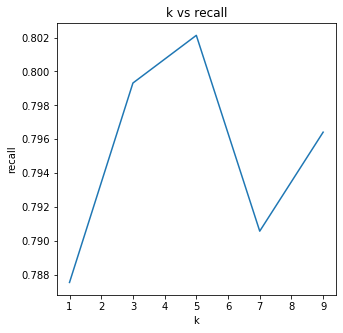

In [22]:
plt.figure(figsize = (5,5))
plt.xlabel('k')
plt.ylabel('recall')
plt.plot(n,cv_score)
plt.title('k vs recall')

In [23]:
time_ = []
recall = []
roc_auc = []

In [24]:
import time
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(df_f_train,df_t_train)
stop_time = time.time()
time_.append(stop_time-start_time )

In [25]:
time_

[2.3300271034240723]

In [26]:
predicted_test = knn.predict(df_f_test)
cm1 = confusion_matrix(df_t_test,predicted_test)
cm1

array([[85284,    11],
       [   34,   114]], dtype=int64)

Text(24.0, 0.5, 'Truth')

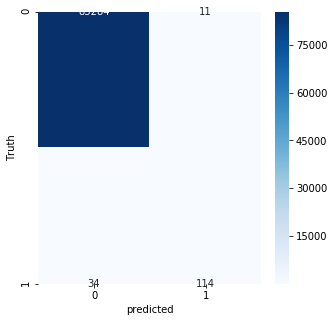

In [27]:
plt.figure(figsize = (5,5))
sns.heatmap(cm1,annot=True,cmap= "Blues",fmt= "d")
plt.xlabel('predicted')
plt.ylabel('Truth')

In [28]:
roc_auc.append(roc_auc_score(df_t_test,predicted_test))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predicted_test))

ROC AUC Score= 0.8850706530435706


Text(0, 0.5, 'True Positive Rate')

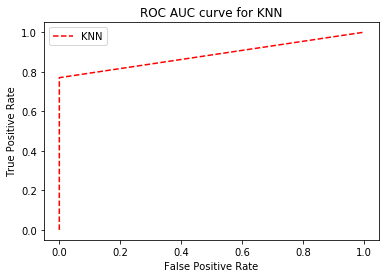

In [29]:
from sklearn.metrics import roc_curve
knn_fpr, knn_tpr ,_ = roc_curve(df_t_test,predicted_test)
plt.plot(knn_fpr, knn_tpr,'r',linestyle='--', label='KNN')
plt.title('ROC AUC curve for KNN')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [30]:
from sklearn.metrics import recall_score

In [31]:
recall.append(recall_score(df_t_test,predicted_test))

In [32]:
print(classification_report(df_t_test,predicted_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.77      0.84       148

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
log_reg = LogisticRegression(solver= 'liblinear')

In [35]:
start_time = time.time()

log_reg.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )

df_t_predicted = log_reg.predict(df_f_test)

In [36]:
cm1 = confusion_matrix(df_t_test,df_t_predicted)
cm1

array([[85280,    15],
       [   59,    89]], dtype=int64)

Text(24.0, 0.5, 'Truth')

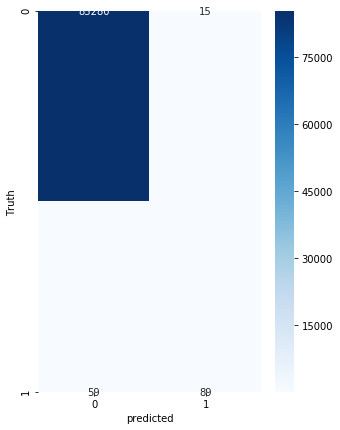

In [37]:
plt.figure(figsize = (5,7))
sns.heatmap(cm1,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [38]:
roc_auc.append(roc_auc_score(df_t_test,df_t_predicted))
print ("ROC AUC Score=",roc_auc_score(df_t_test,df_t_predicted))

ROC AUC Score= 0.8005877455508148


Text(0, 0.5, 'True Positive Rate')

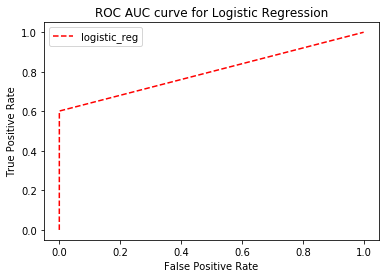

In [39]:
log_reg_fpr, log_reg_tpr ,_ = roc_curve(df_t_test,df_t_predicted)
plt.plot(log_reg_fpr, log_reg_tpr,'r',linestyle='--', label='logistic_reg')
plt.title('ROC AUC curve for Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [40]:
recall.append(recall_score(df_t_test,df_t_predicted))

In [41]:
print(classification_report(df_t_test,df_t_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.60      0.71       148

    accuracy                           1.00     85443
   macro avg       0.93      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443



# SVM Classifier

In [42]:
from sklearn import svm

In [43]:
clf = svm.SVC()

In [44]:
start_time = time.time()

clf.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [45]:
predict = clf.predict(df_f_test)

In [46]:
cm1 = confusion_matrix(df_t_test,predict)
cm1

array([[85291,     4],
       [   50,    98]], dtype=int64)

Text(24.0, 0.5, 'Truth')

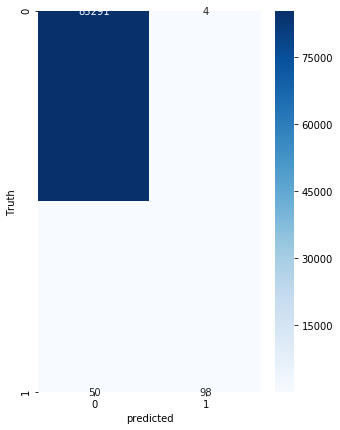

In [47]:
plt.figure(figsize = (5,7))
sns.heatmap(cm1,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [48]:
roc_auc.append(roc_auc_score(df_t_test,predict))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict))

ROC AUC Score= 0.831057633047785


Text(0, 0.5, 'True Positive Rate')

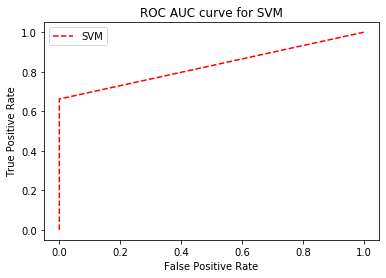

In [49]:
svm_clf_fpr, svm_clf_tpr ,_ = roc_curve(df_t_test,predict)
plt.plot(svm_clf_fpr, svm_clf_tpr,'r',linestyle='--', label='SVM')
plt.title('ROC AUC curve for SVM')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [50]:
recall.append(recall_score(df_t_test,predict))

In [51]:
print(classification_report(df_t_test,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.66      0.78       148

    accuracy                           1.00     85443
   macro avg       0.98      0.83      0.89     85443
weighted avg       1.00      1.00      1.00     85443



# Descision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

start_time = time.time()

tree.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [53]:
predicted_test = tree.predict(df_f_test)
cm_test = confusion_matrix(df_t_test,predicted_test)
cm_test

array([[85253,    42],
       [   43,   105]], dtype=int64)

Text(24.0, 0.5, 'Truth')

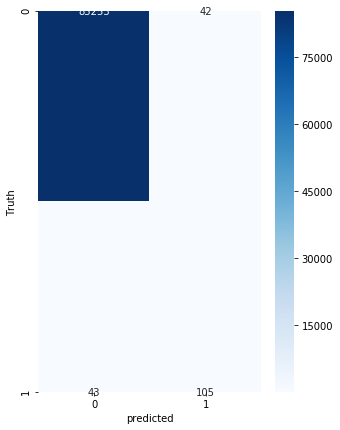

In [54]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [55]:
roc_auc.append(roc_auc_score(df_t_test,predicted_test))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predicted_test))

ROC AUC Score= 0.8544835253801195


Text(0, 0.5, 'True Positive Rate')

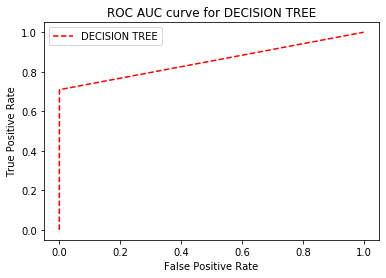

In [56]:
Dtree_clf_fpr, Dtree_clf_tpr ,_ = roc_curve(df_t_test,predicted_test)
plt.plot(Dtree_clf_fpr, Dtree_clf_tpr,'r',linestyle='--', label='DECISION TREE')
plt.title('ROC AUC curve for DECISION TREE')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [57]:
recall.append(recall_score(df_t_test,predicted_test))

In [58]:
print(classification_report(df_t_test,predicted_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.71      0.71      0.71       148

    accuracy                           1.00     85443
   macro avg       0.86      0.85      0.86     85443
weighted avg       1.00      1.00      1.00     85443



# Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
clf3=RandomForestClassifier(n_estimators=200)

In [61]:
start_time = time.time()

clf3.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [62]:
predict3 = clf3.predict(df_f_test)

In [63]:
cm_test = confusion_matrix(df_t_test,predict3)
cm_test

array([[85291,     4],
       [   34,   114]], dtype=int64)

Text(24.0, 0.5, 'Truth')

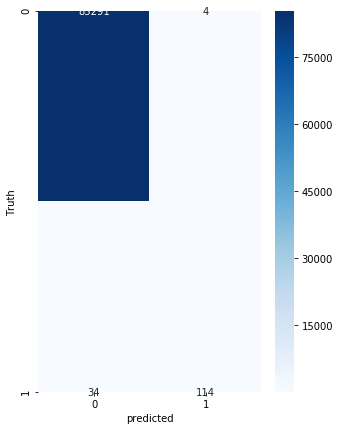

In [64]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [65]:
roc_auc.append(roc_auc_score(df_t_test,predict3))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict3))

ROC AUC Score= 0.8851116871018389


Text(0, 0.5, 'True Positive Rate')

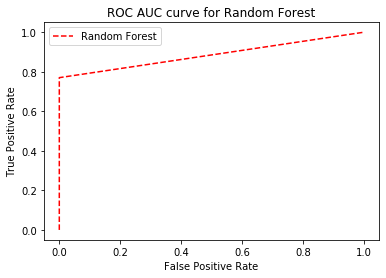

In [66]:
rf_clf_fpr, rf_clf_tpr ,_ = roc_curve(df_t_test,predict3)
plt.plot(rf_clf_fpr, rf_clf_tpr,'r',linestyle='--', label='Random Forest')
plt.title('ROC AUC curve for Random Forest')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [67]:
recall.append(recall_score(df_t_test,predicted_test))

In [68]:
print(classification_report(df_t_test,predict3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.77      0.86       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



# XGBoost 

In [69]:
from xgboost import XGBClassifier

In [70]:
clf1 = XGBClassifier()

In [71]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [72]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(clf1,param_distributions=params,n_iter = 5,scoring = 'recall')

In [73]:
random_search.fit(df_f_train,df_t_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           verbosity=None),
                   iid='deprecated', n_iter=5, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                            

In [74]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [75]:
class_weight = int(df_t_train.value_counts()[0]/df_t_train.value_counts()[1])

In [76]:
xgbc = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [77]:
start_time = time.time()

xgbc.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )



In [78]:
predict1 = xgbc.predict(df_f_test)

In [79]:
cm_test = confusion_matrix(df_t_test,predict1)
cm_test

array([[85291,     4],
       [   36,   112]], dtype=int64)

Text(24.0, 0.5, 'Truth')

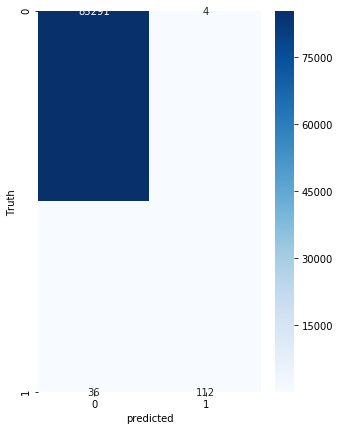

In [80]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [81]:
roc_auc.append(roc_auc_score(df_t_test,predict1))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict1))

ROC AUC Score= 0.8783549303450823


Text(0, 0.5, 'True Positive Rate')

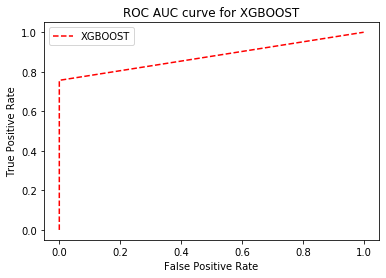

In [82]:
xgb_clf_fpr, xgb_clf_tpr ,_ = roc_curve(df_t_test,predict1)
plt.plot(xgb_clf_fpr, xgb_clf_tpr ,'r',linestyle='--', label='XGBOOST')
plt.title('ROC AUC curve for XGBOOST')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [83]:
recall.append(recall_score(df_t_test,predict1))

In [84]:
print(classification_report(df_t_test,predict1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [85]:
xgbc = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight = class_weight, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [86]:
xgbc.fit(df_f_train,df_t_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=578, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [87]:
predict1 = xgbc.predict(df_f_test)

In [88]:
cm_test = confusion_matrix(df_t_test,predict1)
cm_test

array([[85285,    10],
       [   29,   119]], dtype=int64)

Text(24.0, 0.5, 'Truth')

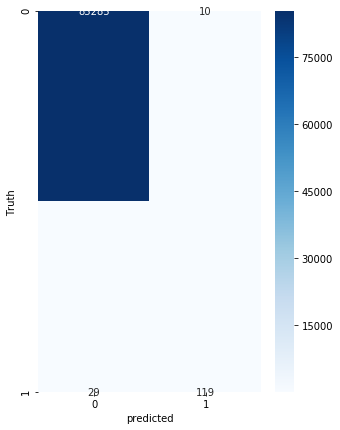

In [89]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [90]:
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict1))

ROC AUC Score= 0.9019684069437864


In [91]:
print(classification_report(df_t_test,predict1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.80      0.86       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



# LightGBM

In [92]:
from lightgbm import LGBMClassifier

In [93]:
clf1 = LGBMClassifier()

In [94]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [95]:
random_search = RandomizedSearchCV(clf1,param_distributions=params,n_iter = 5,scoring = 'recall')

In [96]:
random_search.fit(df_f_train,df_t_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, s...
                                            subsample_freq=0),
                   iid='deprecated', n_iter=5, n_jobs=None,
  

In [97]:
random_search.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               gamma=0.2, importance_type='split', learning_rate=0.15,
               max_depth=3, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [98]:
lgmc = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               gamma=0.3, importance_type='split', learning_rate=0.3,
               max_depth=3, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [99]:
start_time = time.time()

lgmc.fit(df_f_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [100]:
predict1 = lgmc.predict(df_f_test)

In [101]:
cm_test = confusion_matrix(df_t_test,predict1)
cm_test

array([[85228,    67],
       [   40,   108]], dtype=int64)

Text(24.0, 0.5, 'Truth')

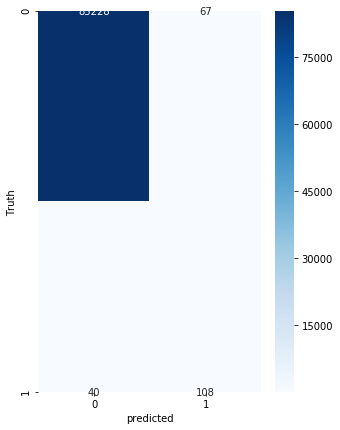

In [102]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [103]:
roc_auc.append(roc_auc_score(df_t_test,predict1))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict1))

ROC AUC Score= 0.8644721103071534


Text(0, 0.5, 'True Positive Rate')

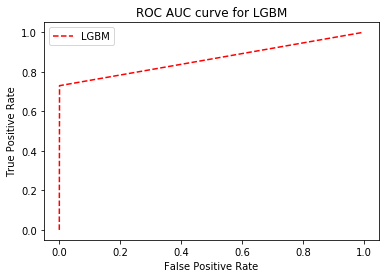

In [104]:
lgbm_clf_fpr, lgbm_clf_tpr ,_ = roc_curve(df_t_test,predict1)
plt.plot(lgbm_clf_fpr, lgbm_clf_tpr ,'r',linestyle='--', label='LGBM')
plt.title('ROC AUC curve for LGBM')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [105]:
recall.append(recall_score(df_t_test,predict1))

In [106]:
print(classification_report(df_t_test,predict1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.62      0.73      0.67       148

    accuracy                           1.00     85443
   macro avg       0.81      0.86      0.83     85443
weighted avg       1.00      1.00      1.00     85443



# Sampling to deal with class imbalance

# Random Forest

In [107]:
from imblearn.under_sampling import NearMiss

In [108]:
# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss(sampling_strategy = {0:100000 , 1: 492})
X_res,y_res=nm.fit_sample(df_f,df_t)

In [109]:
X_res.shape,y_res.shape

((100492, 10), (100492,))

In [110]:
clf3=RandomForestClassifier(n_estimators=200,random_state = 42)

In [111]:
df3_train,df3_test,df_t_train,df_t_test = train_test_split(X_res,y_res,test_size = .3,stratify = y_res,random_state = 42)

In [112]:
start_time = time.time()

clf3.fit(df3_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [113]:
predict3 = clf3.predict(df3_test)

In [114]:
cm_test = confusion_matrix(df_t_test,predict3)
cm_test

array([[29997,     3],
       [   21,   127]], dtype=int64)

Text(24.0, 0.5, 'Truth')

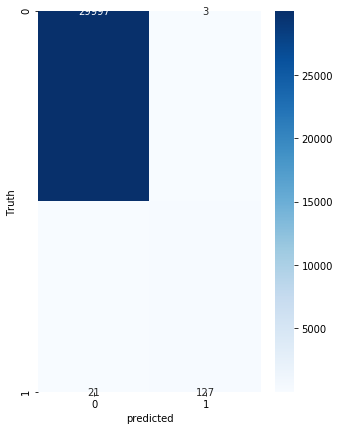

In [115]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [116]:
roc_auc.append(roc_auc_score(df_t_test,predict3))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict3))

ROC AUC Score= 0.9290040540540541


Text(0, 0.5, 'True Positive Rate')

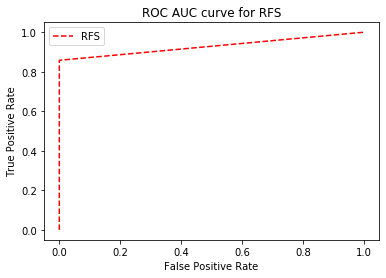

In [117]:
rf_clf_fpr, rf_clf_tpr ,_ = roc_curve(df_t_test,predict3)
plt.plot(rf_clf_fpr, rf_clf_tpr ,'r',linestyle='--', label='RFS')
plt.title('ROC AUC curve for RFS')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [118]:
recall.append(recall_score(df_t_test,predict3))
print(classification_report(df_t_test,predict3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000
           1       0.98      0.86      0.91       148

    accuracy                           1.00     30148
   macro avg       0.99      0.93      0.96     30148
weighted avg       1.00      1.00      1.00     30148



# XGBoost

In [119]:
clf1 = XGBClassifier(random_state = 42)

In [120]:
# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss(sampling_strategy = {0:100000 , 1: 492})
X_res,y_res=nm.fit_sample(df_f,df_t)

In [121]:
X_res.shape,y_res.shape

((100492, 10), (100492,))

In [122]:
df3_train,df3_test,df_t_train,df_t_test = train_test_split(X_res,y_res,test_size = .3,stratify = y_res,random_state = 42)

In [123]:
start_time = time.time()

clf1.fit(df3_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [124]:
predict3 = clf1.predict(df3_test)

In [125]:
cm_test = confusion_matrix(df_t_test,predict3)
cm_test

array([[29997,     3],
       [   23,   125]], dtype=int64)

Text(24.0, 0.5, 'Truth')

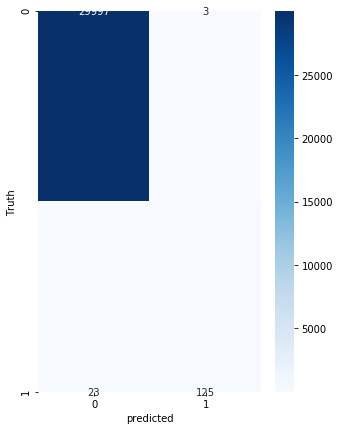

In [126]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [127]:
roc_auc.append(roc_auc_score(df_t_test,predict3))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict3))

ROC AUC Score= 0.9222472972972975


Text(0, 0.5, 'True Positive Rate')

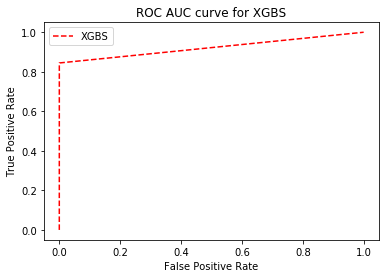

In [128]:
xgb_clf_fpr, xgb_clf_tpr ,_ = roc_curve(df_t_test,predict3)
plt.plot(xgb_clf_fpr, xgb_clf_tpr ,'r',linestyle='--', label='XGBS')
plt.title('ROC AUC curve for XGBS')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [129]:
recall.append(recall_score(df_t_test,predict3))
print(classification_report(df_t_test,predict3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000
           1       0.98      0.84      0.91       148

    accuracy                           1.00     30148
   macro avg       0.99      0.92      0.95     30148
weighted avg       1.00      1.00      1.00     30148



# LightGBM

In [130]:
clf1 = LGBMClassifier()

In [131]:
start_time = time.time()

clf1.fit(df3_train,df_t_train)

stop_time = time.time()

time_.append(stop_time-start_time )


In [132]:
predict3 = clf1.predict(df3_test)

In [133]:
cm_test = confusion_matrix(df_t_test,predict3)
cm_test

array([[29970,    30],
       [   32,   116]], dtype=int64)

Text(24.0, 0.5, 'Truth')

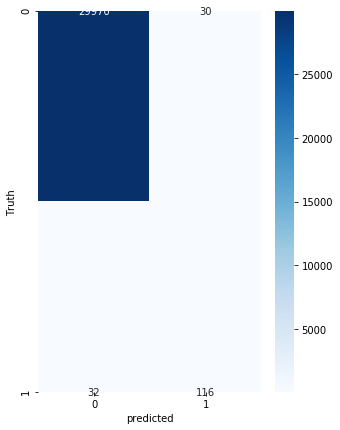

In [134]:
plt.figure(figsize = (5,7))
sns.heatmap(cm_test,cmap= "Blues",fmt= "d",annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [135]:
roc_auc.append(roc_auc_score(df_t_test,predict3))
print ("ROC AUC Score=",roc_auc_score(df_t_test,predict3))

ROC AUC Score= 0.8913918918918919


Text(0, 0.5, 'True Positive Rate')

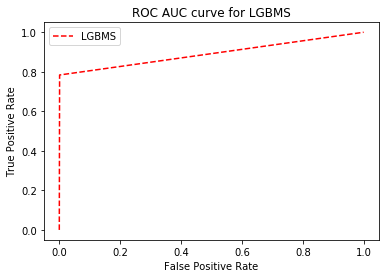

In [136]:
lgbm_clf_fpr, lgbm_clf_tpr ,_ = roc_curve(df_t_test,predict3)
plt.plot(lgbm_clf_fpr, lgbm_clf_tpr ,'r',linestyle='--', label='LGBMS')
plt.title('ROC AUC curve for LGBMS')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [137]:
recall.append(recall_score(df_t_test,predict3))
print(classification_report(df_t_test,predict3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000
           1       0.79      0.78      0.79       148

    accuracy                           1.00     30148
   macro avg       0.90      0.89      0.89     30148
weighted avg       1.00      1.00      1.00     30148



In [138]:
print(recall,roc_auc,time_,sep = '\n')

[0.7702702702702703, 0.6013513513513513, 0.6621621621621622, 0.7094594594594594, 0.7094594594594594, 0.7567567567567568, 0.7297297297297297, 0.8581081081081081, 0.8445945945945946, 0.7837837837837838]
[0.8850706530435706, 0.8005877455508148, 0.831057633047785, 0.8544835253801195, 0.8851116871018389, 0.8783549303450823, 0.8644721103071534, 0.9290040540540541, 0.9222472972972975, 0.8913918918918919]
[2.3300271034240723, 1.3638718128204346, 87.2228090763092, 8.6964693069458, 357.176150560379, 46.08322787284851, 2.5120036602020264, 112.10940766334534, 14.323462724685669, 1.104907512664795]


In [139]:
clcfr = ['KNN','LOGISTIC REGRESSION','SVM','DECISION TREE' ,'RANDOM FOREST','XGBOOST','LGBM','RFS','XGBS','LGBMS']

Text(0.5, 1.0, 'Classifier vs Training Time')

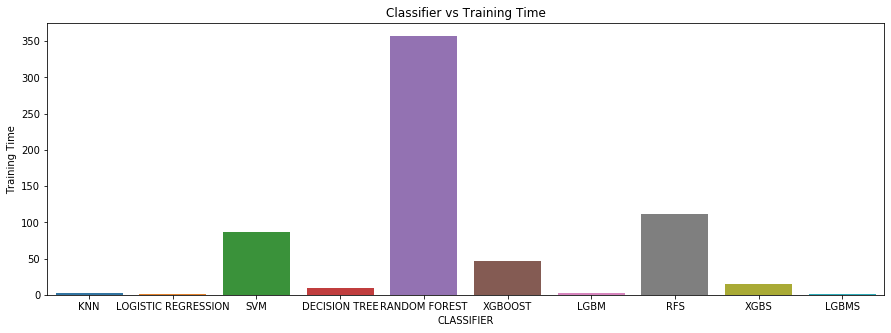

In [140]:
import seaborn as sns
plt.figure(figsize = (15,5))
sns.barplot(x = clcfr, y = time_)
plt.xlabel('CLASSIFIER')
plt.ylabel('Training Time')
plt.title('Classifier vs Training Time')

Text(0.5, 1.0, 'Classifier vs RECALL')

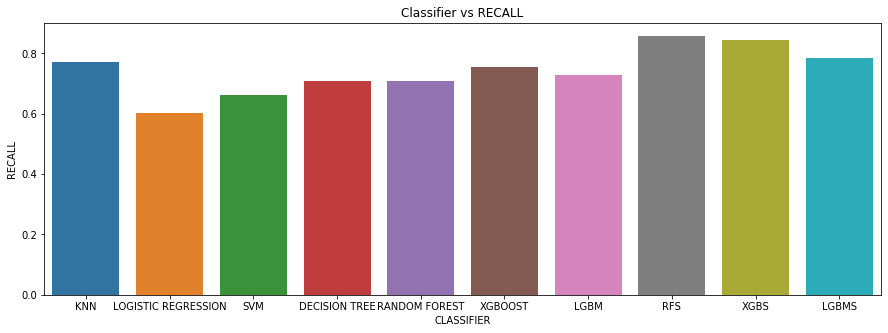

In [141]:
import seaborn as sns
plt.figure(figsize = (15,5))
sns.barplot(x = clcfr, y = recall)
plt.xlabel('CLASSIFIER')
plt.ylabel('RECALL')
plt.title('Classifier vs RECALL')

Text(0.5, 1.0, 'Classifier vs ROC AUC SCORE')

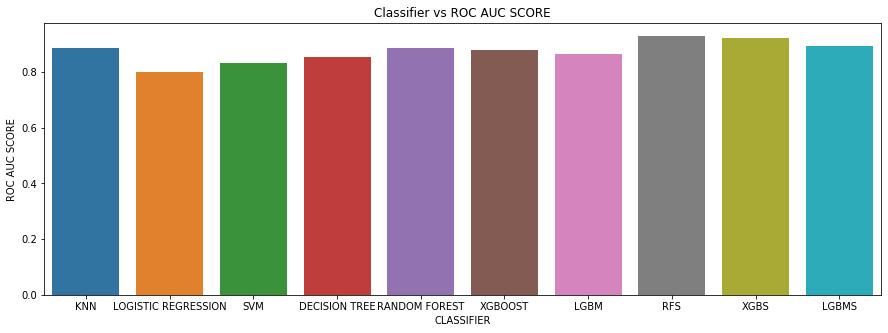

In [142]:
import seaborn as sns
plt.figure(figsize = (15,5))
sns.barplot(x = clcfr, y = roc_auc)
plt.xlabel('CLASSIFIER')
plt.ylabel('ROC AUC SCORE')
plt.title('Classifier vs ROC AUC SCORE')